<a href="https://colab.research.google.com/github/aromaldev/OCR-Malayalam/blob/master/Segmentation/Segmentation_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import shutil
# shutil.rmtree('lines')
# shutil.rmtree('words')
# shutil.rmtree('chars')

In [ ]:
#RLSA 
import numpy as np

def iteration(image: np.ndarray, value: int) -> np.ndarray:
    """
    This method iterates over the provided image by converting 255's to 0's if the number of consecutive 255's are
    less the "value" provided
    """

    rows, cols = image.shape
    for row in range(0,rows):
        try:
            start = image[row].tolist().index(0) # to start the conversion from the 0 pixel
        except ValueError:
            start = 0 # if '0' is not present in that row

        count = start
        for col in range(start, cols):
            if image[row, col] == 0:
                if (col-count) <= value and (col-count) > 0:
                    image[row, count:col] = 0               
                count = col  
    return image 

def hvrlsa(image: np.ndarray, horizontal: bool = True,  vertical: bool = True, hvalue: int =0, vvalue: int = 0) -> np.ndarray:
    """
    rlsa(RUN LENGTH SMOOTHING ALGORITHM) is to extract the block-of-text or the Region-of-interest(ROI) from the
    document binary Image provided. Must pass binary image of ndarray type.
    """
    
    if isinstance(image, np.ndarray): # image must be binary of ndarray type
        hvalue = int(hvalue) if hvalue>=0 else 0 # consecutive pixel position checker value to convert 255 to 0
        vvalue = int(vvalue) if vvalue>=0 else 0
        try:
            # RUN LENGTH SMOOTHING ALGORITHM working horizontally on the image
            if horizontal:
                image = iteration(image, hvalue)   

            # RUN LENGTH SMOOTHING ALGORITHM working vertically on the image
            if vertical:
                image = image.T
                image = iteration(image, vvalue)
                image = image.T

        except (AttributeError, ValueError) as e:
            image = None
            print("ERROR: ", e, "\n")
            print('Image must be an numpy ndarray and must be in "binary". Use Opencv/PIL to convert the image to binary.\n')
            print("import cv2;\nimage=cv2.imread('path_of_the_image');\ngray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY);\n\
                (thresh, image_binary) = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)\n")
            print("method usage -- rlsa.rlsa(image_binary, True, False, 10)")
    else:
        print('Image must be an numpy ndarray and must be in binary')
        image = None
    return image

def hpp(image: np.ndarray):
  hp = [0]*image.shape[0]
  for i in range(0,image.shape[0]):
    hp[i]=0
    for j in range(0,image.shape[1]):
      hp[i] += image[i][j]
  return hp
 
def split_lines(img: np.ndarray,count):
  hp = hpp(~img)
  #cv2_imshow(img)
  #print("HPP",hp)
  peaks, _ = find_peaks(hp, height=0)
  #peaks, _ = find_peaks(hp, distance=91)      #make distance relative
  xhp=np.array(hp)/1000
  peaks, _ = find_peaks(xhp, prominence=38)
  print("peaks:",peaks)
  plt.plot(xhp)
  plt.plot(peaks, xhp[peaks], "x")
  a=0
  for i in range(0,len(peaks)-1):
    min_ind=hp.index(min(hp[peaks[i]:peaks[i+1]]),peaks[i],peaks[i+1])
    #print("Min index ", min_ind," between ", peaks[i], "and ",peaks[i+1], "value:",hp[min_ind])
    split1 = img[a:min_ind]
    a = min_ind
    print("Split Line ",i+1)
    count += 1
    save("lines/line"+str(count)+".jpg",split1)
    # cv2_imshow(split1)
    wordseg(split1)
  split1=img[min_ind:]
  print("Split Line ",i+2)
  count += 1
  save("lines/line"+str(count)+".jpg",split1)
  # cv2_imshow(split1)
  wordseg(split1)
  return len(peaks)

def mask(gray,roi_thresh,ctr,x,y,w,h):
  mask=~np.zeros_like(gray)
  cv2.drawContours(mask,[ctr],0, (0,0,0), -1)
  roi_mask=mask[y:y+h,x:x+w]
  roi_thresh=cv2.bitwise_or(roi_mask,roi_thresh)
  return roi_thresh

def save(path, img):
    #tmp = np.asarray(img*255.0, dtype=np.uint8)
    Image.fromarray(img).save(path)

In [ ]:
def charseg(word):
  global wcount, lcount, chcount
  # Morphological Closing
  kernel = np.ones((3,3), np.uint8)
  closed=cv2.morphologyEx(~word,cv2.MORPH_CLOSE,kernel)
  # print("Word after RLSA")
  cv2_imshow(closed)

  #Finding  and sorting Contours
  ctrs, hier = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  sorted_ctrs = sorted(ctrs, key=lambda ctr: (cv2.boundingRect(ctr)[0]))
  count = 0  # to store number of words
    #Extracting characters from the word

  for i, ctr in enumerate(sorted_ctrs):
    #Getting bounding box of character
    x, y, w, h = cv2.boundingRect(ctr)
    #Getting ROI of character from ROI of word 
    roi = word[y:y+h, x:x+w]

    #Only characters greater than a particular size are extracted
    #This cutoff should be smaller then smallest character to avoid loss of character
    if(roi.shape[0]>12 and roi.shape[1]>11):
      print('\n\n\ncharacter segment no:'+str(i))
      print("Height: ",roi.shape[0], "Width: ",roi.shape[1])
      #print("Location:\tx: ",cx,"\ty: ",cy)
      charoi = mask(word,roi,ctr,x,y,w,h)
      cv2_imshow(charoi)
      chcount += 1
      count += 1
      save("chars/char"+str(chcount)+"("+str(lcount)+")"+".jpg",roi)
      # save("drive/MyDrive/testchars/"+str(chcount)+".jpg",roi)
  print("No. of characters: ",count)
  print("Cumulative character count: ",chcount)

In [ ]:
def wordseg(line):
  global wcount, lcount
  # Morphological Closing
  kernel = np.ones((22,image.shape[1]//55), np.uint8)
  closed=cv2.morphologyEx(~line,cv2.MORPH_CLOSE,kernel)
  # print("Closed line")
  # cv2_imshow(closed)

  #Finding  and sorting Contours
  ctrs, hier = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  sorted_ctrs = sorted(ctrs, key=lambda ctr: (cv2.boundingRect(ctr)[0]))
  # copy_img = line.copy()
  # print("Word Contours")
  # cv2.drawContours(copy_img, ctrs, -1, (0, 255, 0), 3)
  # cv2_imshow(copy_img) 

  count = 0  # to store number of words
  for i, ctr in enumerate(sorted_ctrs):
      # Get bounding box
      x, y, w, h = cv2.boundingRect(ctr)
      # Getting ROI from original image
      roi = line[y:y+h, x:x+w]
      #print('\n\n\nsegment no:'+str(i))
      #print("Height: ",roi.shape[0], "Width: ",roi.shape[1])

      # Only words of greater than a particular size are selected
      if(roi.shape[1]>image.shape[1]//50):
          print('Word segment no:',count)
          print("Location:\tx: ",x,"\ty: ",y)
          cv2_imshow(roi)
          count = count+1
          wcount = wcount+1
          char_count=0
          save("words/word"+str(wcount)+"("+str(lcount)+")"+".jpg",roi)
          charseg(roi)
      

  print("Total number of words: ",count)

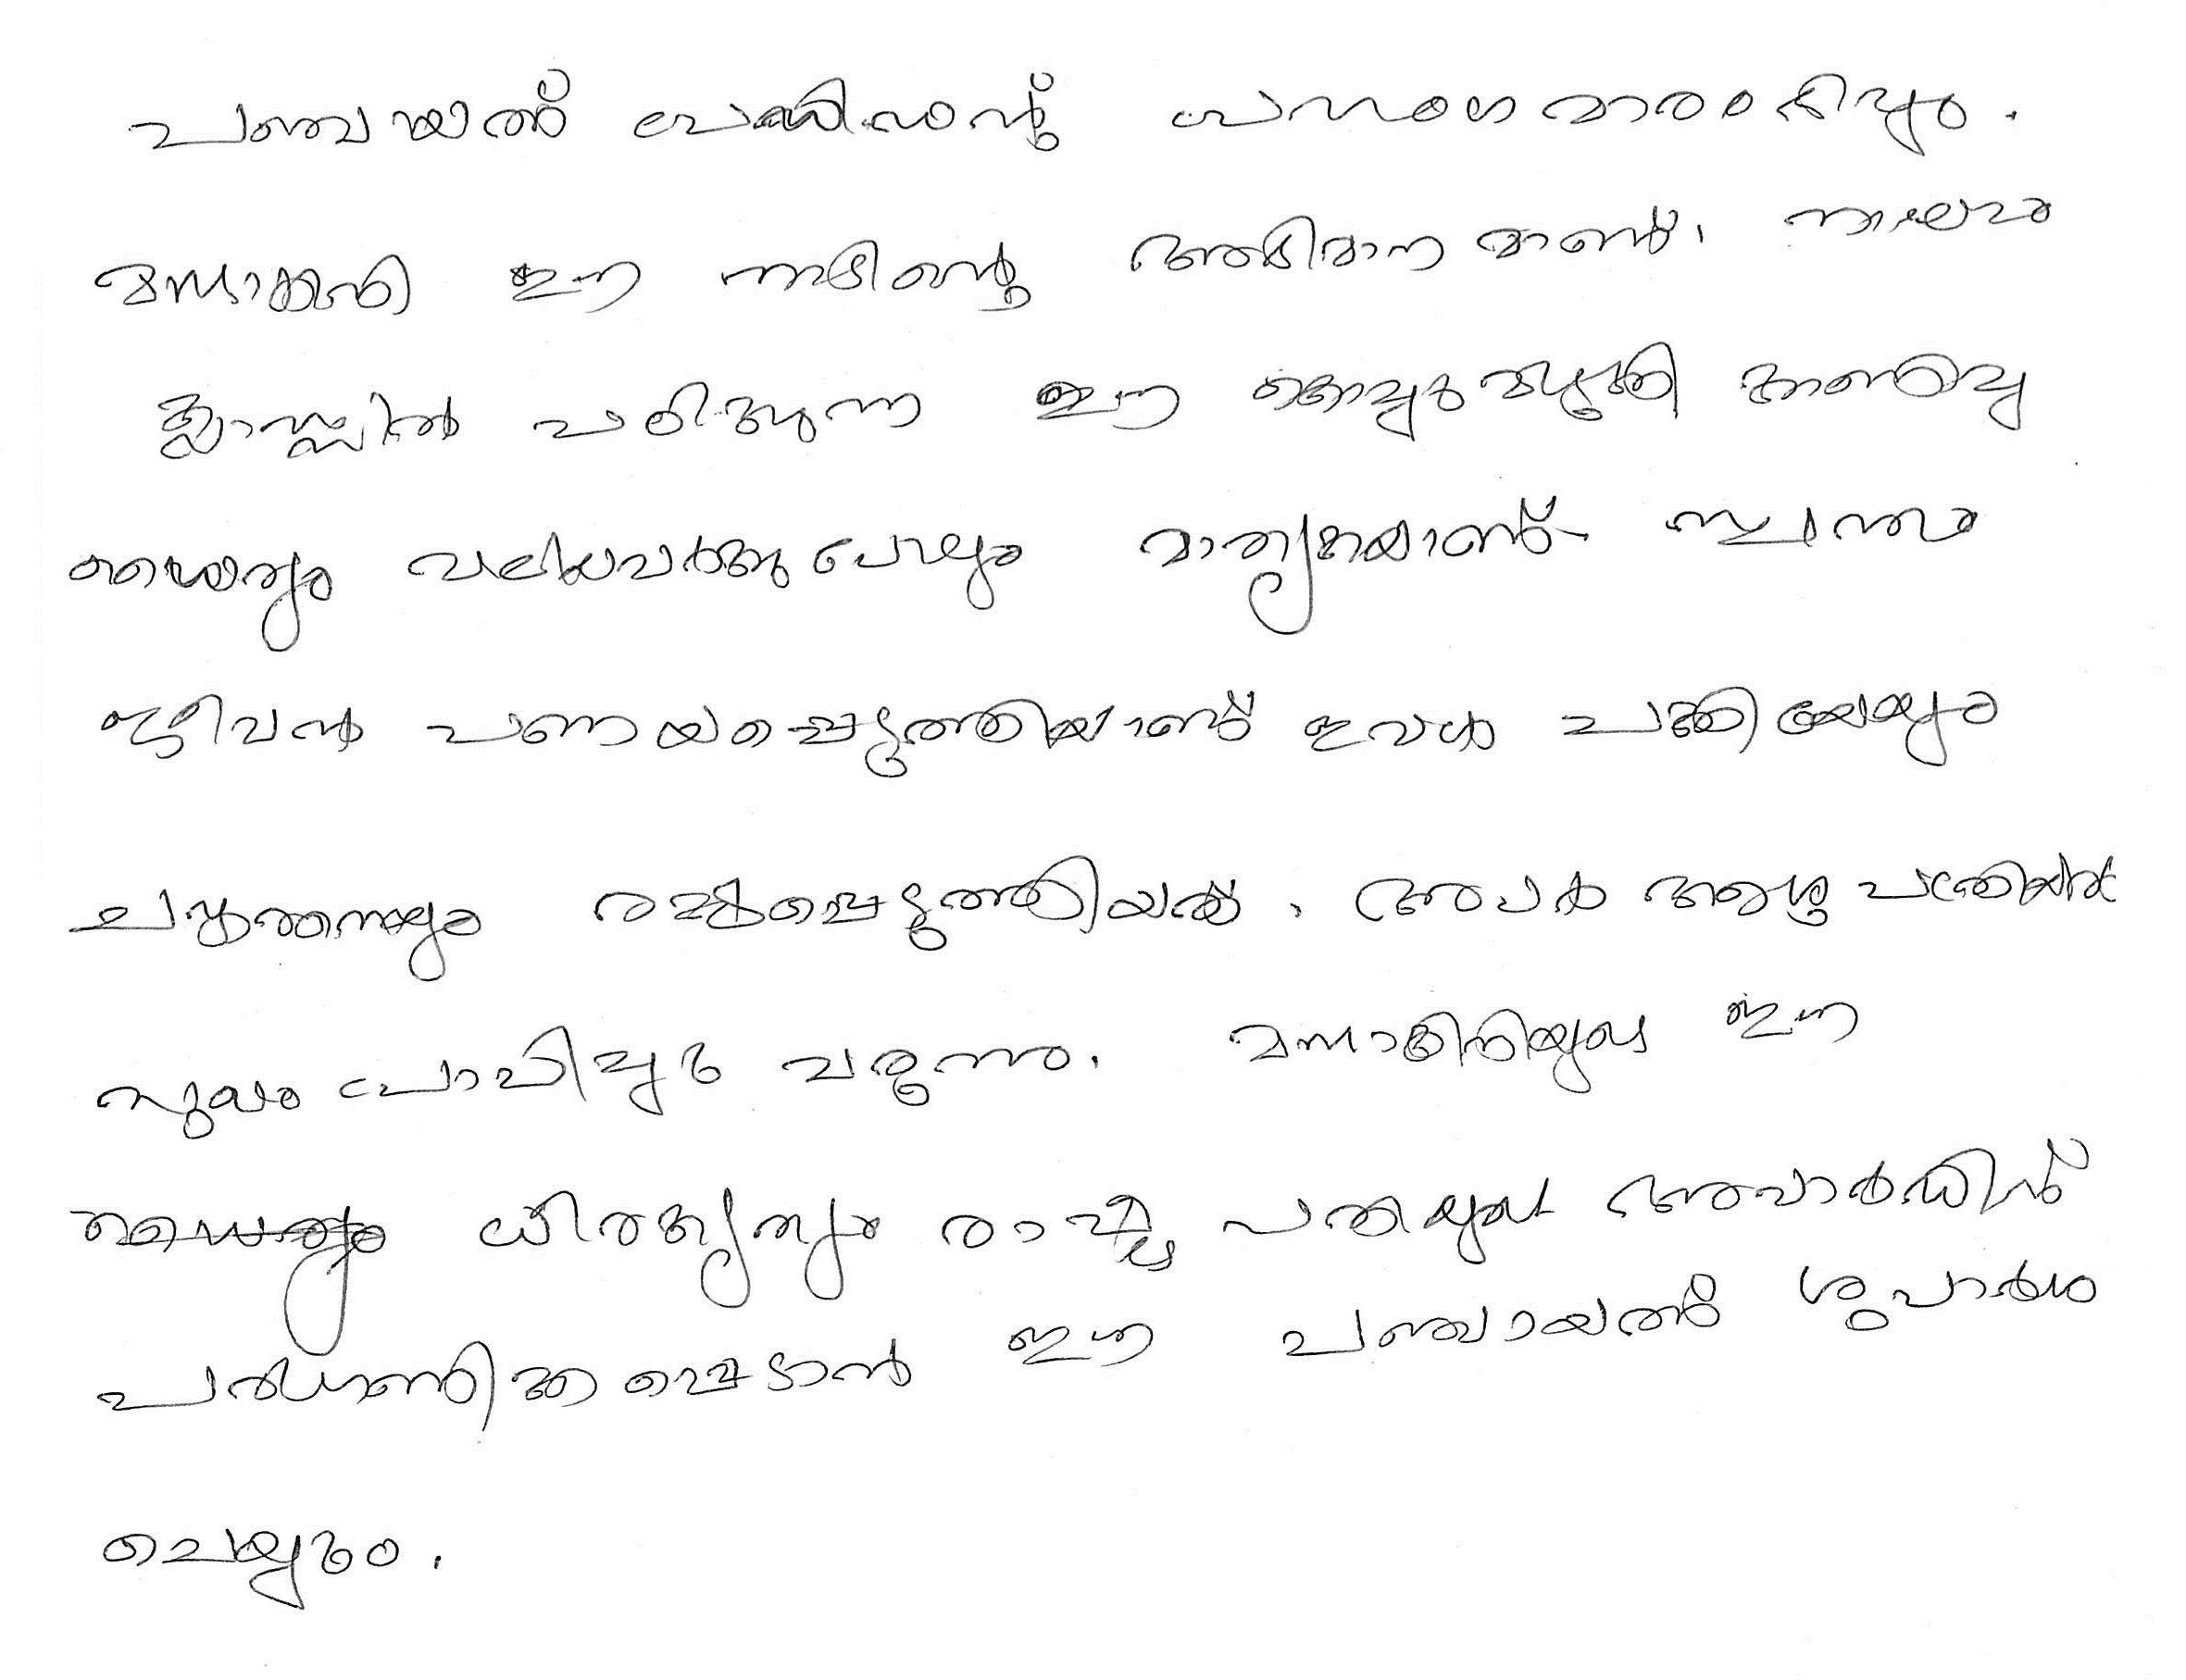

Height:  1815 Width:  2361
Closing


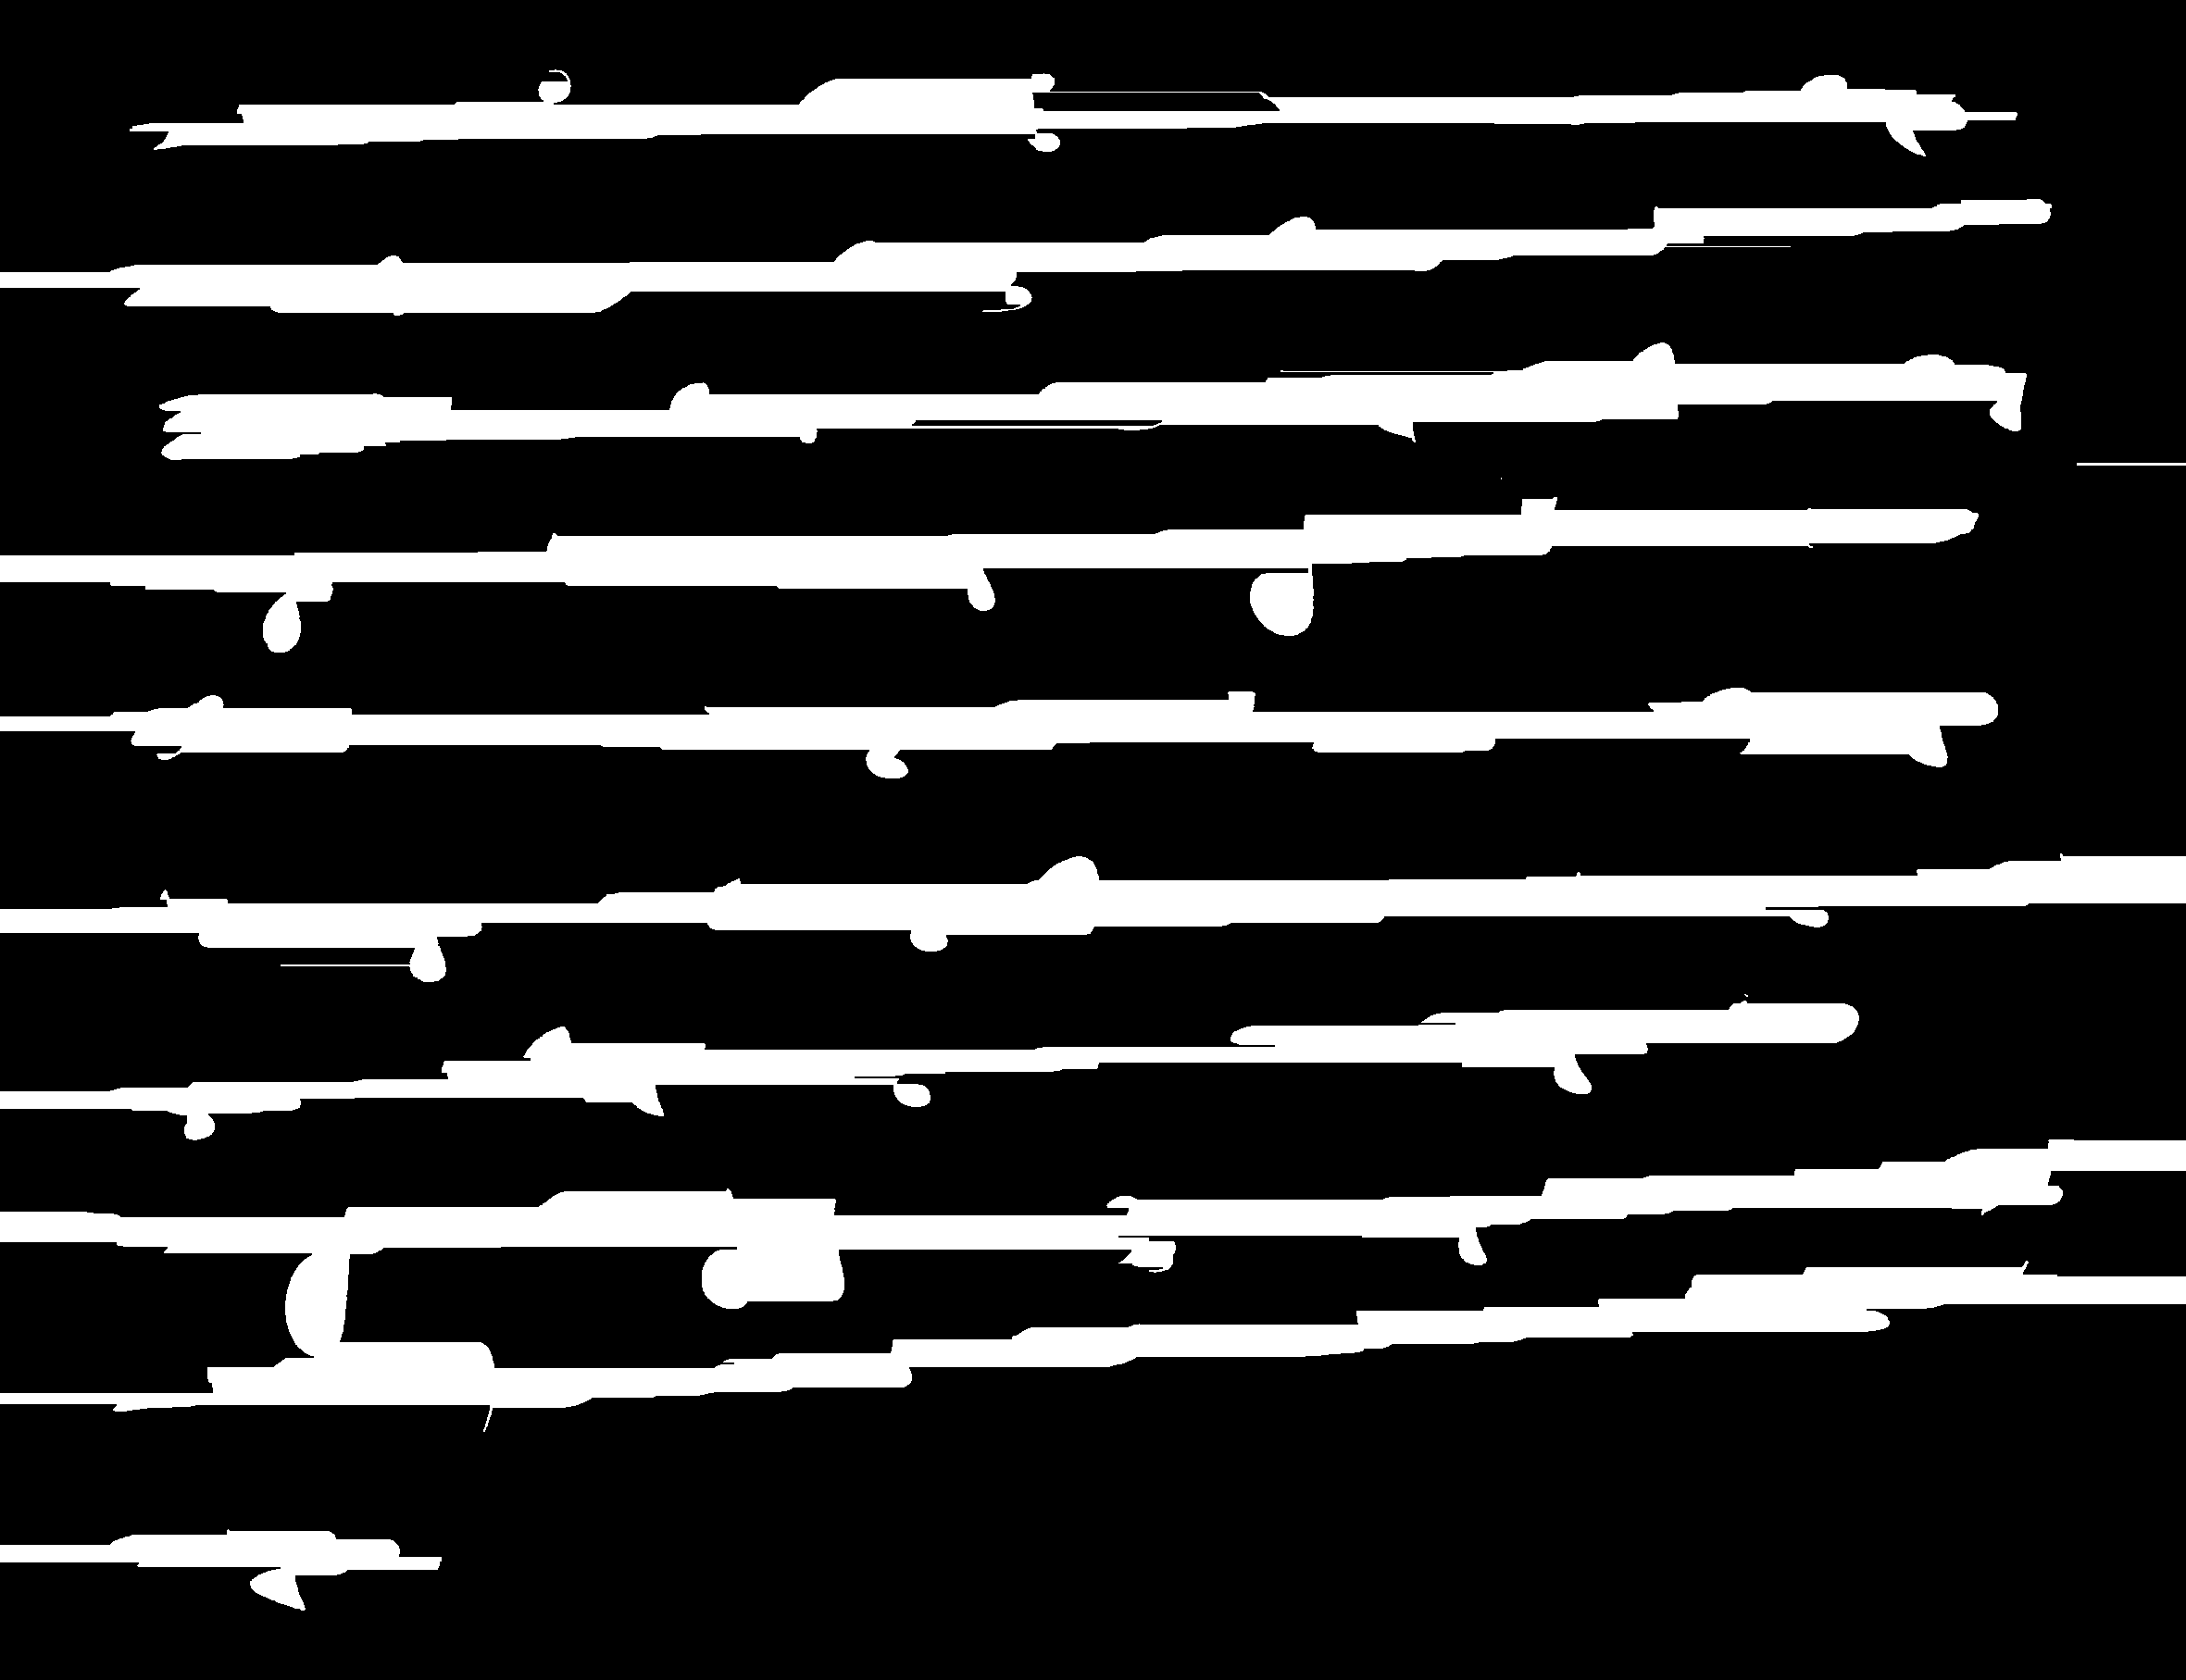

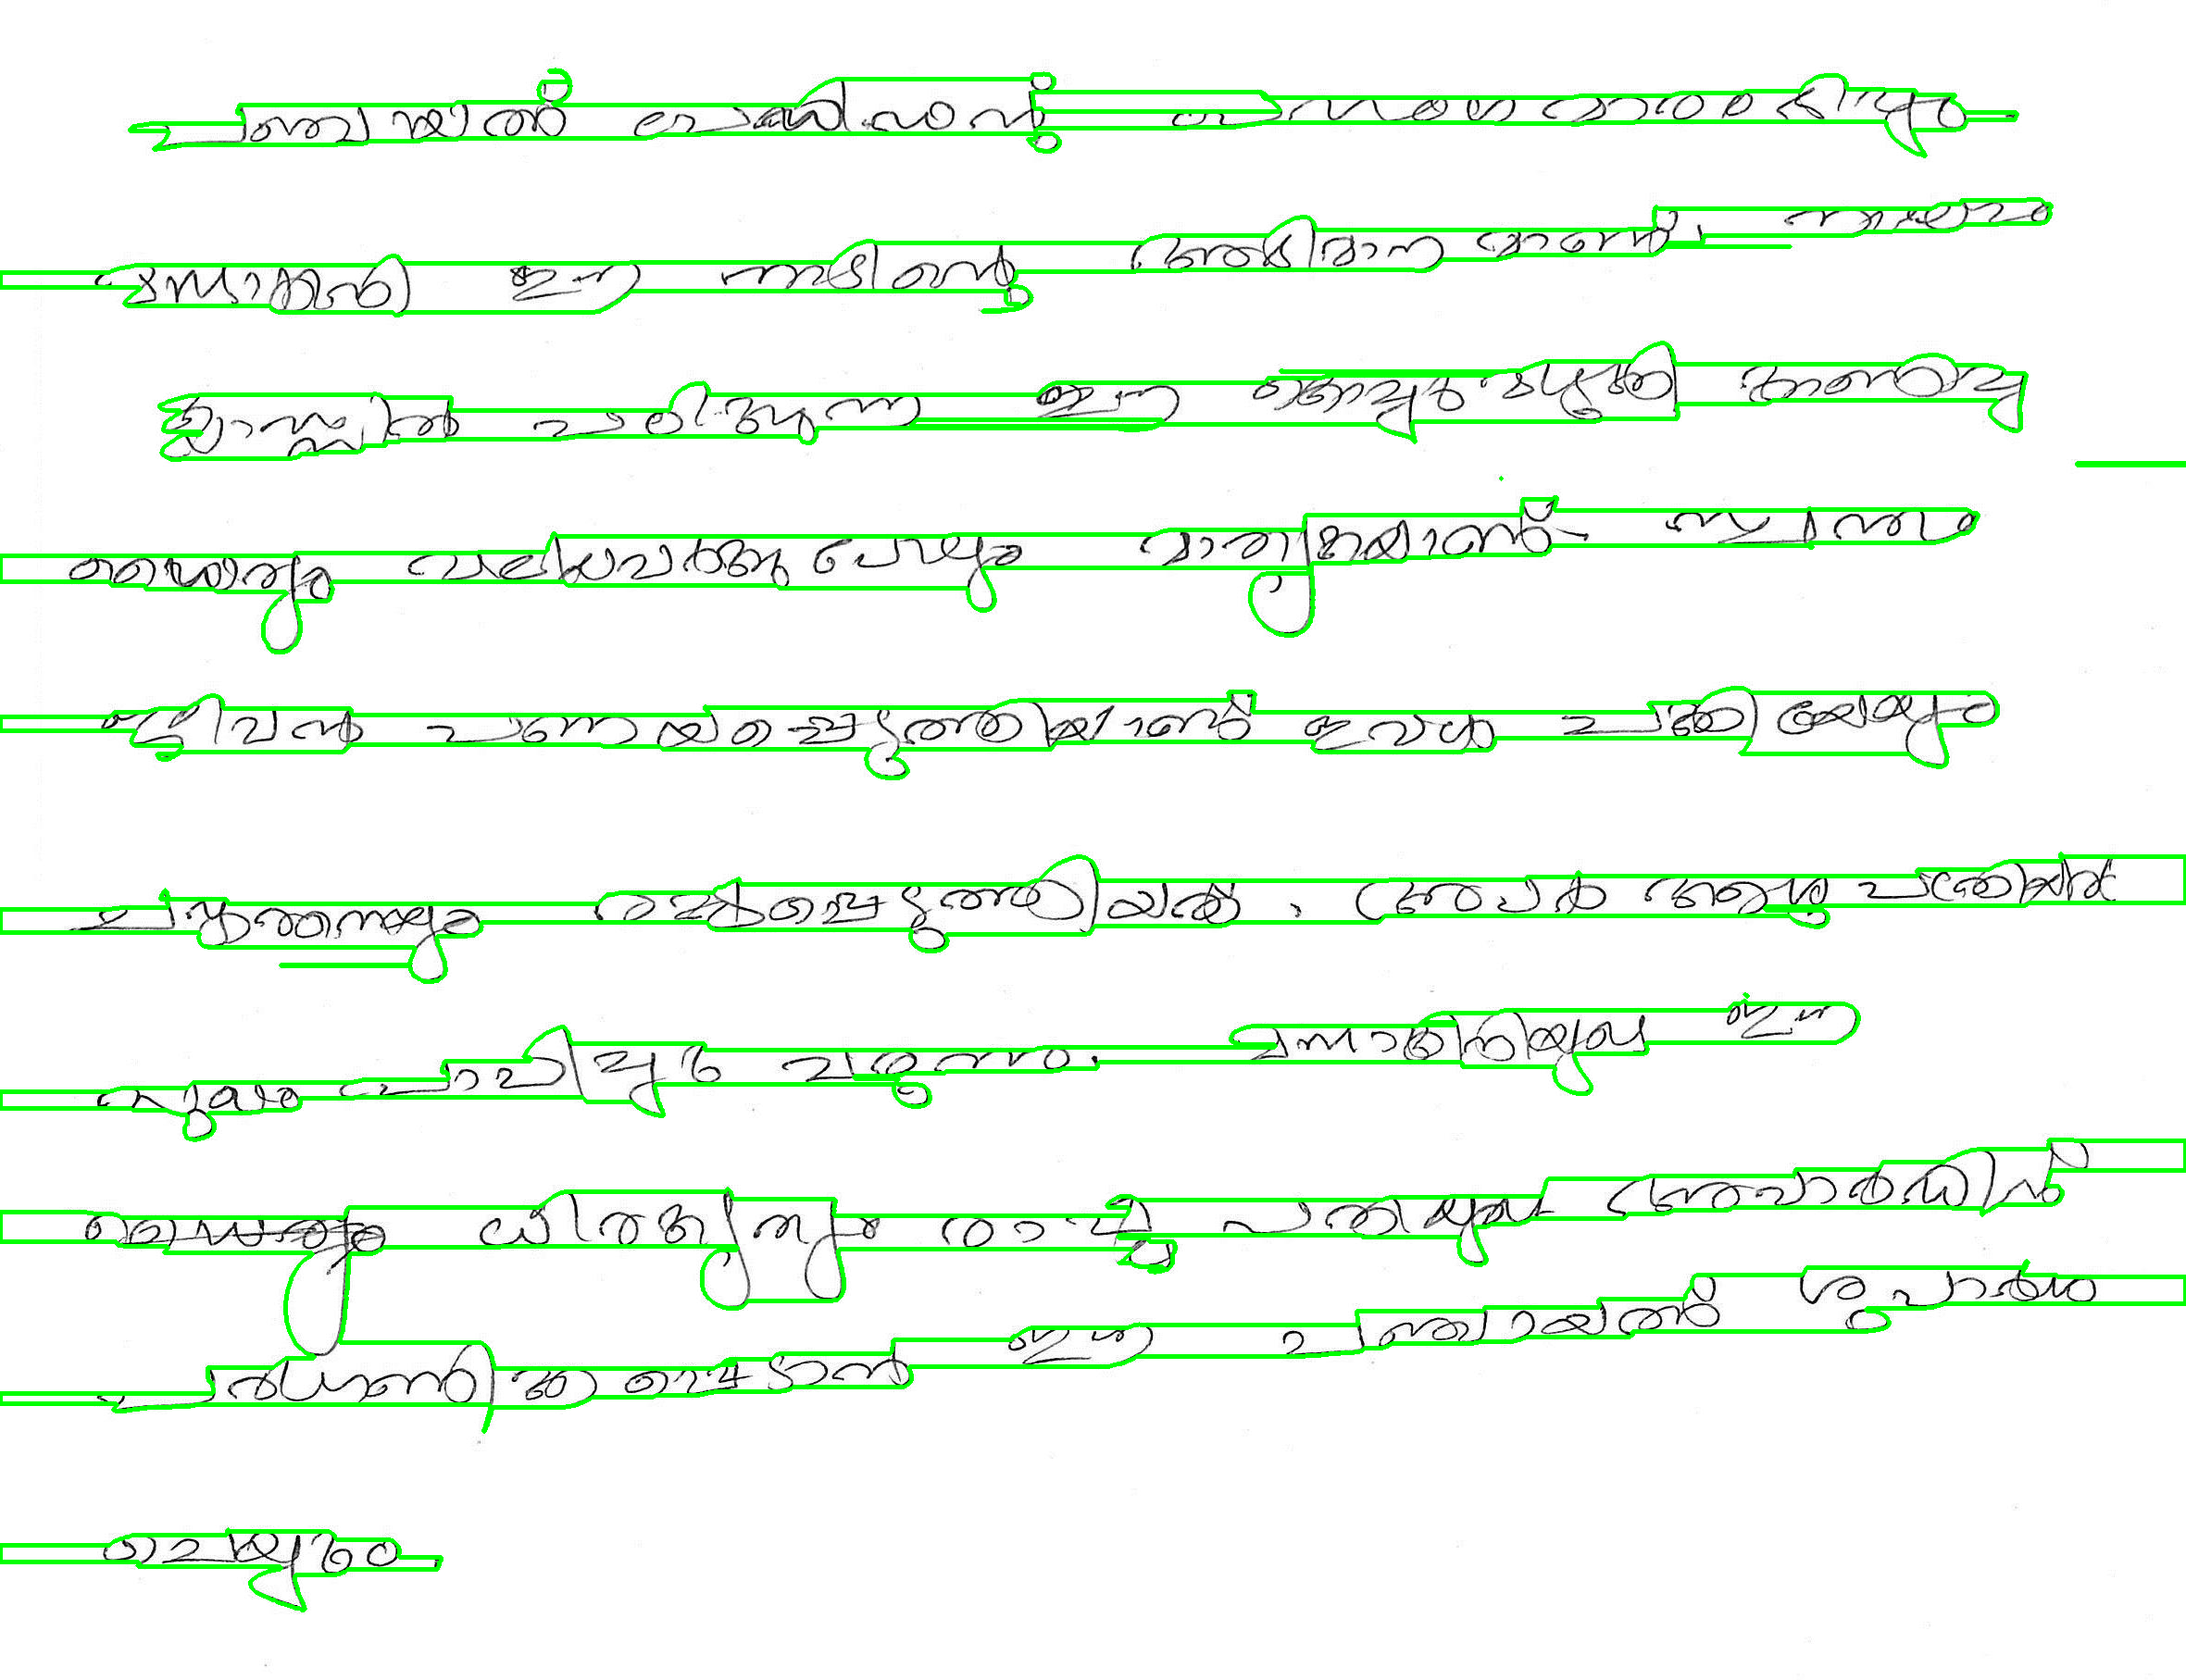

Number of line contours: 14
avg height:  145.22222222222223
undersegmentation threshold:  210.57222222222222
9  ctr heights:  [94, 126, 127, 168, 98, 139, 151, 316, 88]



segment no:0
Height:  94 Width:  2039
Location:	x:  140 	y:  75
Line segment no: 1
Word segment no: 0
Location:	x:  0 	y:  0


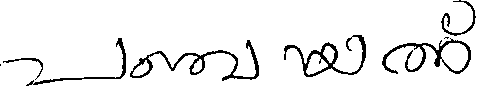

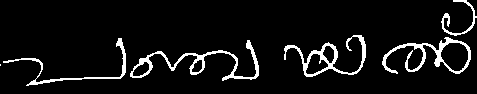




character segment no:1
Height:  48 Width:  123


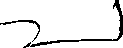




character segment no:2
Height:  41 Width:  129


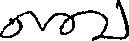




character segment no:3
Height:  42 Width:  82


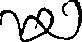




character segment no:4
Height:  37 Width:  89


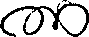




character segment no:5
Height:  36 Width:  36


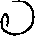

No. of characters:  5
Cumulative character count:  5
Word segment no: 1
Location:	x:  546 	y:  0


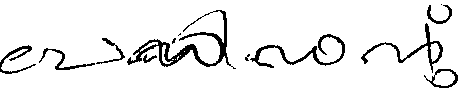

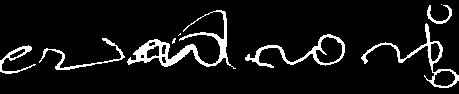




character segment no:0
Height:  29 Width:  36





character segment no:1
Height:  32 Width:  86


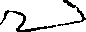




character segment no:2
Height:  59 Width:  109


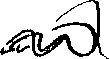




character segment no:5
Height:  34 Width:  100


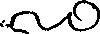




character segment no:6
Height:  65 Width:  98


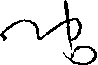




character segment no:7
Height:  19 Width:  25


No. of characters:  6
Cumulative character count:  11
Word segment no: 2
Location:	x:  1127 	y:  0


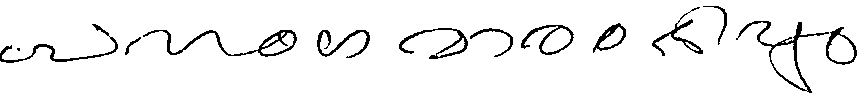

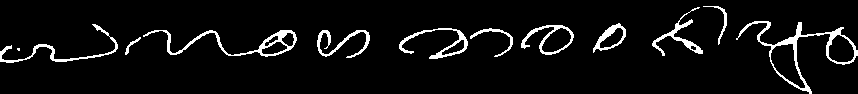




character segment no:0
Height:  39 Width:  118


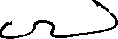




character segment no:2
Height:  18 Width:  16





character segment no:3
Height:  27 Width:  154





character segment no:4
Height:  28 Width:  53





character segment no:5
Height:  31 Width:  69





character segment no:6
Height:  29 Width:  43





character segment no:7
Height:  30 Width:  53





character segment no:8
Height:  30 Width:  33





character segment no:9
Height:  49 Width:  51


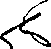




character segment no:10
Height:  39 Width:  24





character segment no:11
Height:  73 Width:  122


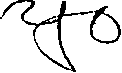

No. of characters:  11
Cumulative character count:  22
Total number of words:  3



segment no:2
Height:  126 Width:  2216
Location:	x:  0 	y:  215
Line segment no: 2
Word segment no: 0
Location:	x:  103 	y:  62


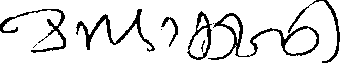

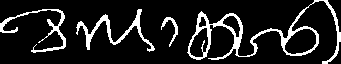




character segment no:0
Height:  44 Width:  66


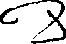




character segment no:1
Height:  43 Width:  79


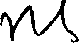




character segment no:2
Height:  30 Width:  17





character segment no:3
Height:  64 Width:  154


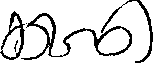

No. of characters:  4
Cumulative character count:  26
Word segment no: 1
Location:	x:  552 	y:  69


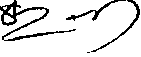

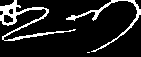




character segment no:0
Height:  41 Width:  76


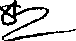




character segment no:1
Height:  52 Width:  75


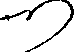

No. of characters:  2
Cumulative character count:  28
Word segment no: 2
Location:	x:  780 	y:  46


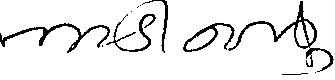

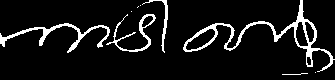




character segment no:0
Height:  30 Width:  110





character segment no:1
Height:  38 Width:  50


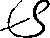




character segment no:5
Height:  53 Width:  26





character segment no:6
Height:  72 Width:  152


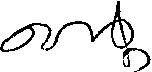

No. of characters:  4
Cumulative character count:  32
Word segment no: 3
Location:	x:  1222 	y:  0


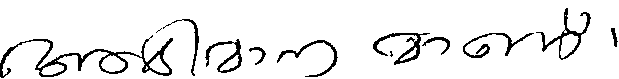

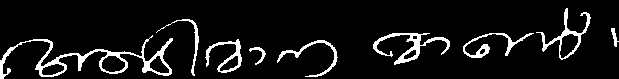




character segment no:0
Height:  44 Width:  173


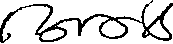




character segment no:1
Height:  57 Width:  43


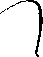




character segment no:2
Height:  34 Width:  37


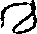




character segment no:3
Height:  18 Width:  17





character segment no:4
Height:  37 Width:  61


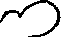




character segment no:5
Height:  32 Width:  77


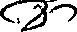




character segment no:6
Height:  25 Width:  71





character segment no:7
Height:  52 Width:  55


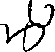

No. of characters:  8
Cumulative character count:  40
Word segment no: 4
Location:	x:  1928 	y:  0


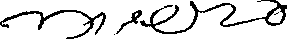

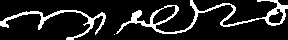




character segment no:0
Height:  30 Width:  106





character segment no:2
Height:  34 Width:  172


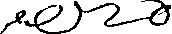

No. of characters:  2
Cumulative character count:  42
Total number of words:  5



segment no:3
Height:  127 Width:  2017
Location:	x:  172 	y:  370
Line segment no: 3
Word segment no: 0
Location:	x:  0 	y:  56


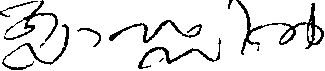

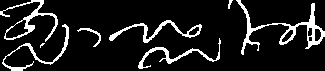




character segment no:0
Height:  42 Width:  58


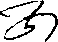




character segment no:1
Height:  47 Width:  67


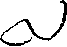




character segment no:3
Height:  19 Width:  24





character segment no:4
Height:  23 Width:  93





character segment no:5
Height:  31 Width:  83





character segment no:7
Height:  55 Width:  89


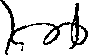

No. of characters:  6
Cumulative character count:  48
Word segment no: 1
Location:	x:  405 	y:  44


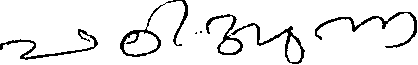

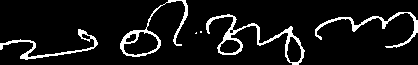




character segment no:0
Height:  31 Width:  98





character segment no:1
Height:  57 Width:  68


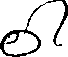




character segment no:4
Height:  51 Width:  99


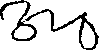




character segment no:5
Height:  36 Width:  103


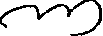

No. of characters:  4
Cumulative character count:  52
Word segment no: 2
Location:	x:  948 	y:  44


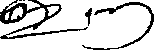

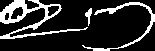




character segment no:0
Height:  39 Width:  88


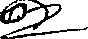




character segment no:1
Height:  49 Width:  73


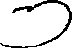

No. of characters:  2
Cumulative character count:  54
Word segment no: 3
Location:	x:  1182 	y:  0


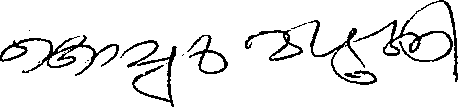

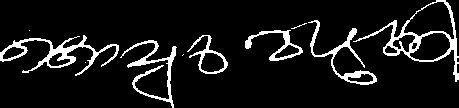




character segment no:0
Height:  41 Width:  119


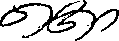




character segment no:3
Height:  68 Width:  57


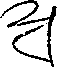




character segment no:5
Height:  39 Width:  41


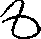




character segment no:6
Height:  31 Width:  58





character segment no:8
Height:  65 Width:  69


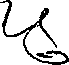




character segment no:9
Height:  82 Width:  106


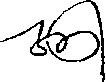

No. of characters:  6
Cumulative character count:  60
Word segment no: 4
Location:	x:  1709 	y:  14


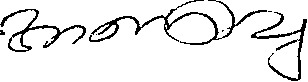

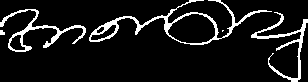




character segment no:1
Height:  43 Width:  86


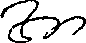




character segment no:2
Height:  45 Width:  183


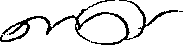




character segment no:4
Height:  70 Width:  57


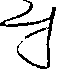

No. of characters:  3
Cumulative character count:  63
Total number of words:  5



segment no:7
Height:  168 Width:  2137
Location:	x:  0 	y:  537
Line segment no: 4
Word segment no: 0
Location:	x:  75 	y:  61


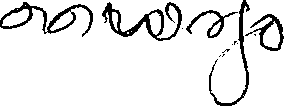

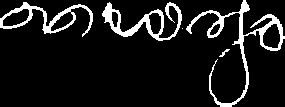




character segment no:0
Height:  35 Width:  93


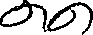




character segment no:1
Height:  39 Width:  80


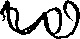




character segment no:3
Height:  107 Width:  99


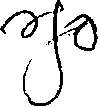

No. of characters:  3
Cumulative character count:  66
Word segment no: 1
Location:	x:  441 	y:  40


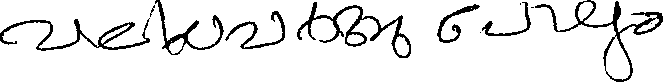

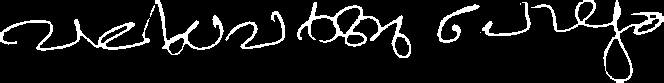




character segment no:0
Height:  33 Width:  150


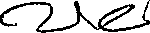




character segment no:2
Height:  55 Width:  69


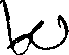




character segment no:3
Height:  38 Width:  60


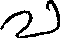




character segment no:4
Height:  56 Width:  114


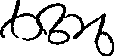




character segment no:5
Height:  39 Width:  43


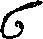




character segment no:7
Height:  34 Width:  49


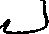




character segment no:9
Height:  83 Width:  133


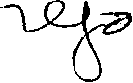

No. of characters:  7
Cumulative character count:  73
Word segment no: 2
Location:	x:  1232 	y:  0


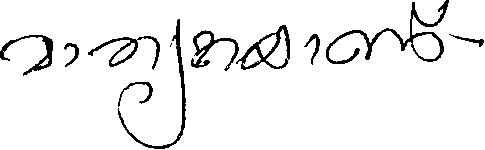

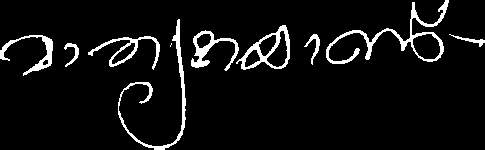




character segment no:0
Height:  41 Width:  53


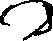




character segment no:1
Height:  24 Width:  15





character segment no:2
Height:  34 Width:  72


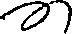




character segment no:3
Height:  131 Width:  68


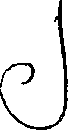




character segment no:5
Height:  41 Width:  48


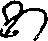




character segment no:6
Height:  45 Width:  54


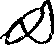




character segment no:7
Height:  31 Width:  16





character segment no:8
Height:  64 Width:  123


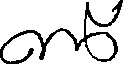




character segment no:9
Height:  13 Width:  36


No. of characters:  9
Cumulative character count:  82
Word segment no: 3
Location:	x:  1800 	y:  13


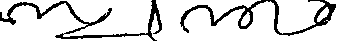

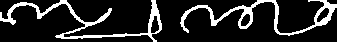




character segment no:0
Height:  42 Width:  162


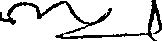




character segment no:1
Height:  36 Width:  157


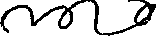

No. of characters:  2
Cumulative character count:  84
Total number of words:  4



segment no:8
Height:  98 Width:  2158
Location:	x:  0 	y:  743
Line segment no: 5
Word segment no: 0
Location:	x:  110 	y:  0


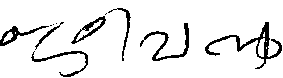

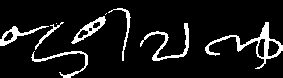




character segment no:0
Height:  20 Width:  49





character segment no:1
Height:  27 Width:  57





character segment no:2
Height:  28 Width:  29





character segment no:4
Height:  28 Width:  35





character segment no:6
Height:  53 Width:  23





character segment no:7
Height:  38 Width:  49


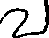




character segment no:8
Height:  47 Width:  78


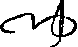

No. of characters:  7
Cumulative character count:  91
Word segment no: 1
Location:	x:  462 	y:  0


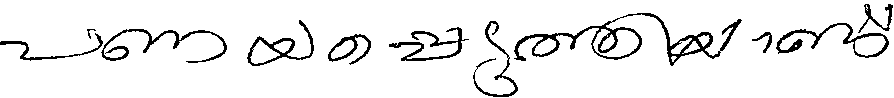

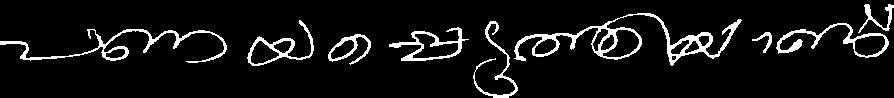




character segment no:0
Height:  34 Width:  227


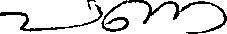




character segment no:1
Height:  46 Width:  67


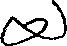




character segment no:2
Height:  31 Width:  43





character segment no:3
Height:  34 Width:  80


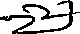




character segment no:4
Height:  77 Width:  45


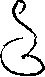




character segment no:5
Height:  53 Width:  228


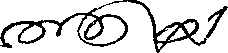




character segment no:6
Height:  21 Width:  20





character segment no:7
Height:  35 Width:  113


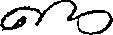




character segment no:8
Height:  29 Width:  36


No. of characters:  9
Cumulative character count:  100
Word segment no: 2
Location:	x:  1410 	y:  27


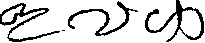

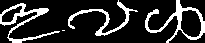




character segment no:0
Height:  40 Width:  60


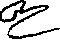




character segment no:2
Height:  36 Width:  70


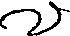




character segment no:3
Height:  43 Width:  60


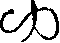

No. of characters:  3
Cumulative character count:  103
Word segment no: 3
Location:	x:  1688 	y:  0


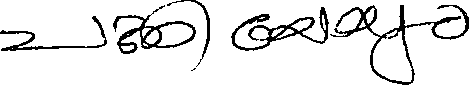

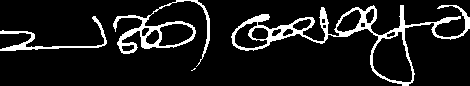




character segment no:0
Height:  35 Width:  107


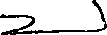




character segment no:1
Height:  67 Width:  97


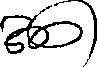




character segment no:3
Height:  81 Width:  239


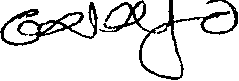

No. of characters:  3
Cumulative character count:  106
Total number of words:  4



segment no:9
Height:  139 Width:  2361
Location:	x:  0 	y:  922
Line segment no: 6
Word segment no: 0
Location:	x:  76 	y:  40


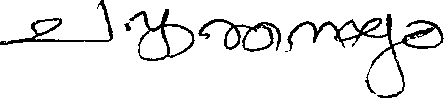

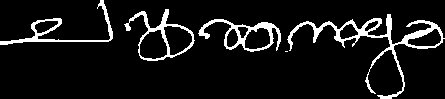




character segment no:0
Height:  45 Width:  113


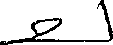




character segment no:1
Height:  52 Width:  71


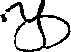




character segment no:2
Height:  33 Width:  83


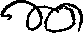




character segment no:4
Height:  85 Width:  158


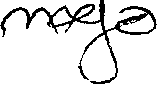

No. of characters:  4
Cumulative character count:  110
Word segment no: 1
Location:	x:  642 	y:  0


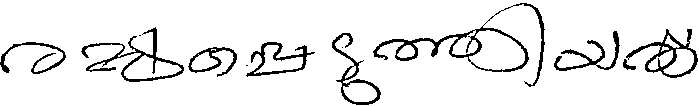

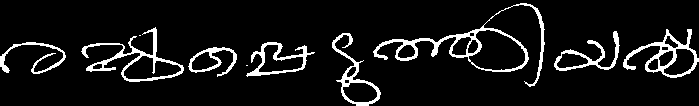




character segment no:0
Height:  32 Width:  66


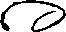




character segment no:1
Height:  55 Width:  103


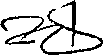




character segment no:3
Height:  30 Width:  49





character segment no:5
Height:  35 Width:  69


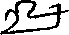




character segment no:6
Height:  73 Width:  49


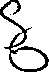




character segment no:7
Height:  84 Width:  172


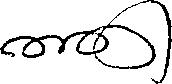




character segment no:8
Height:  40 Width:  66


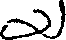




character segment no:9
Height:  49 Width:  76


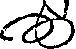

No. of characters:  8
Cumulative character count:  118
Word segment no: 2
Location:	x:  1465 	y:  0


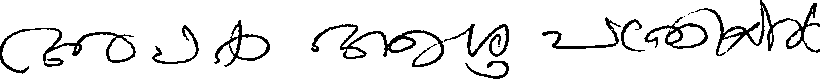

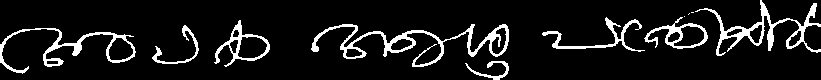




character segment no:0
Height:  46 Width:  136


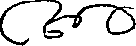




character segment no:1
Height:  39 Width:  47


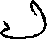




character segment no:2
Height:  47 Width:  56


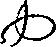




character segment no:3
Height:  43 Width:  198


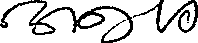




character segment no:4
Height:  19 Width:  44





character segment no:5
Height:  35 Width:  103


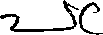




character segment no:6
Height:  32 Width:  64


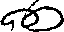




character segment no:10
Height:  56 Width:  126


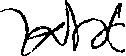

No. of characters:  8
Cumulative character count:  126
Total number of words:  3



segment no:11
Height:  151 Width:  2008
Location:	x:  0 	y:  1081
Line segment no: 7
Word segment no: 0
Location:	x:  106 	y:  89


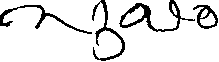

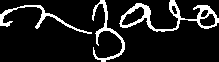




character segment no:0
Height:  29 Width:  92





character segment no:1
Height:  62 Width:  33


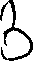




character segment no:2
Height:  32 Width:  100


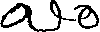

No. of characters:  3
Cumulative character count:  129
Word segment no: 1
Location:	x:  367 	y:  29


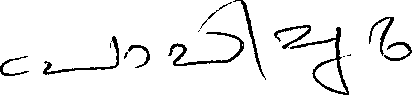

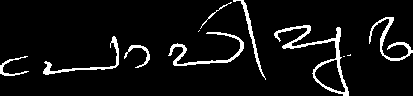




character segment no:0
Height:  20 Width:  29





character segment no:1
Height:  39 Width:  76


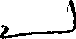




character segment no:2
Height:  23 Width:  26





character segment no:3
Height:  34 Width:  76


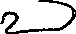




character segment no:5
Height:  27 Width:  32





character segment no:6
Height:  80 Width:  33


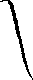




character segment no:7
Height:  71 Width:  75


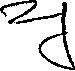




character segment no:10
Height:  44 Width:  44


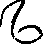

No. of characters:  8
Cumulative character count:  137
Word segment no: 2
Location:	x:  845 	y:  51


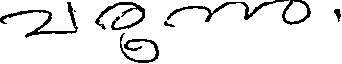

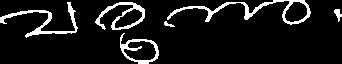




character segment no:0
Height:  36 Width:  78


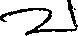




character segment no:1
Height:  28 Width:  50





character segment no:2
Height:  31 Width:  39





character segment no:4
Height:  25 Width:  144


No. of characters:  4
Cumulative character count:  141
Word segment no: 3
Location:	x:  1330 	y:  0


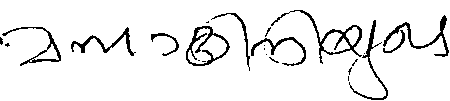

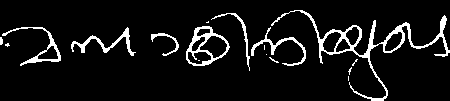




character segment no:1
Height:  39 Width:  59


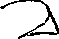




character segment no:3
Height:  29 Width:  65





character segment no:4
Height:  23 Width:  28





character segment no:5
Height:  40 Width:  44


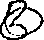




character segment no:7
Height:  58 Width:  39


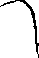




character segment no:8
Height:  39 Width:  55


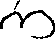




character segment no:12
Height:  91 Width:  179


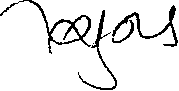

No. of characters:  7
Cumulative character count:  148
Word segment no: 4
Location:	x:  1866 	y:  0


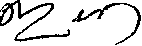

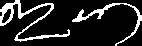




character segment no:0
Height:  42 Width:  70


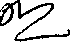




character segment no:1
Height:  43 Width:  70


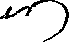

No. of characters:  2
Cumulative character count:  150
Total number of words:  5
Undersegmented line
Height:  316 Width:  2361


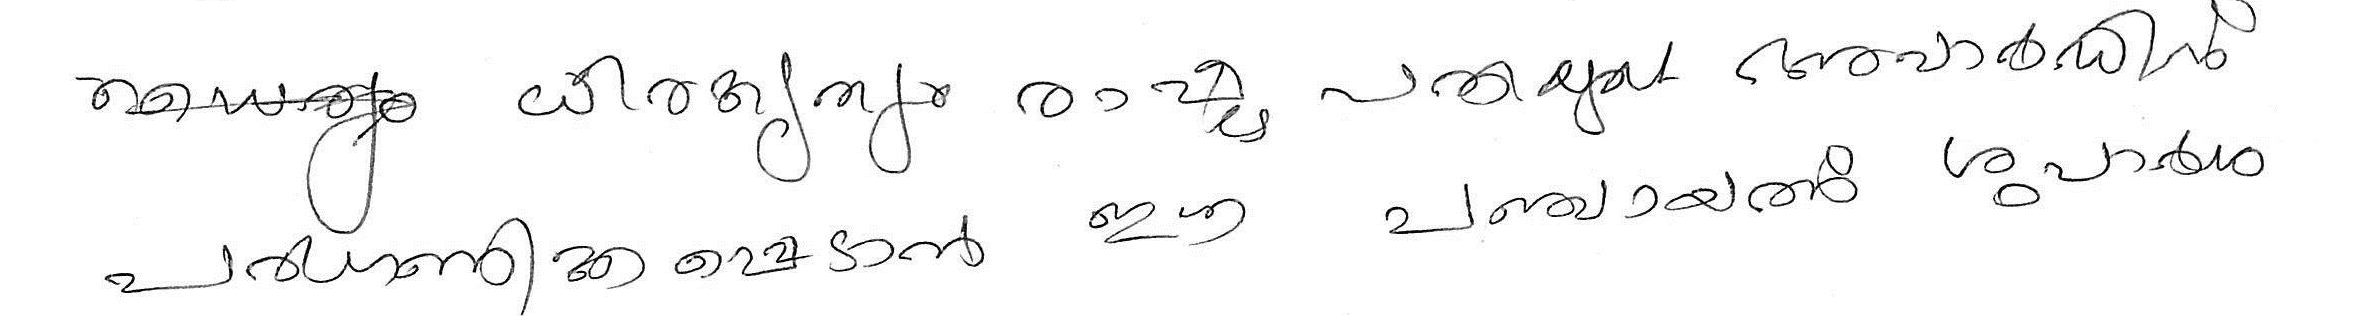

peaks: [100]


UnboundLocalError: ignored

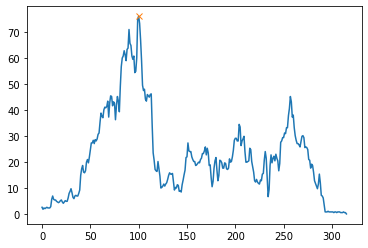

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from statistics import mean, stdev
from google.colab.patches import cv2_imshow
from google.colab import files

#Loading image
image = cv2.imread("/content/drive/MyDrive/malayalam1/p_mal_0103.tif");
cv2_imshow(image)                             # display original image

#Creating directory to store segmented lines
os.makedirs("lines", exist_ok=True)
os.makedirs("words", exist_ok=True)
os.makedirs("chars", exist_ok=True)

#Converting to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("Height: ",image.shape[0], "Width: ",image.shape[1])
#print("Grayscale Image")
#cv2_imshow(gray)

#Thresholding
ret,thresh = cv2.threshold(gray,160,255,cv2.THRESH_BINARY) 
#print("After thresholding")
#cv2_imshow(thresh)


         #@title Kernel size parameters for Morphological Closing
print("Closing")
ver = 660 #@param {type:'slider', min:1,max: 1270}
hor = 10 #@param {type:'slider', min:1,max:70}
lh = 23 #@param {type:'slider', min:1,max:100}
kernel = np.ones((image.shape[0]//ver,image.shape[1]//hor), np.uint8)
closing=cv2.morphologyEx(~thresh,cv2.MORPH_CLOSE,kernel)
#closing=hvrlsa(thresh.copy(),True,True,image.shape[1]//hor,lh)
cv2_imshow(closing)
lcount = 0
wcount = 0
chcount = 0

ctrs, hier = cv2.findContours(closing.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
copy_img = image.copy()
cv2.drawContours(copy_img, ctrs, -1, (0, 255, 0), 3)
cv2_imshow(copy_img)


                  #sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[1])
print("Number of line contours:", len(sorted_ctrs))
ctr_height = []   #to store height of each contour
for i, ctr in enumerate(sorted_ctrs):
  _,_,w,h = cv2.boundingRect(ctr)
  if(w>image.shape[1]//50 and h>image.shape[0]//40):
    ctr_height.append(h)
avg_height = mean(ctr_height)
print("avg height: ",avg_height)
print("undersegmentation threshold: ",avg_height*1.45)
print(len(ctr_height)," ctr heights: ",ctr_height)
ucount =0
for i, ctr in enumerate(sorted_ctrs):
 
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
 
    # Getting ROI
    roi = image[y:y+h, x:x+w]
    roi_thresh=thresh[y:y+h,x:x+w]
    if(roi.shape[1]>image.shape[1]//50 and roi.shape[0]>image.shape[0]//40):
      if(roi.shape[0]<avg_height*1.45):         #undersegmentation threshold
        roi_thresh = mask(gray,roi_thresh,ctr,x,y,w,h)
        
        # show ROI
        print('\n\n\nsegment no:'+str(i))
        print("Height: ",roi.shape[0], "Width: ",roi.shape[1])
        print("Location:\tx: ",x,"\ty: ",y)
        #cv2_imshow(roi)
        # cv2_imshow(roi_thresh)
        lcount=lcount+1 
        save("lines/line"+str(lcount)+".jpg",roi_thresh)
   
        print('Line segment no:',lcount)
        #plt.imshow(roi)
        #plt.show()
        #cv2_imshow(roi)
        #cv2.imwrite("/home/word_seg_project/word_output/"+"00"+str(count)+".jpg",roi)
        wordseg(roi_thresh)
        
      else:
        print("Undersegmented line")
        print("Height: ",roi.shape[0], "Width: ",roi.shape[1])
        cv2_imshow(roi)
        ucount+=1
        lcount+=split_lines(roi_thresh, lcount)
        #hp=hpp(roi)
        #for i in range(0,len(hp)):
          #print("Horizontal Pp row ", i,hp[i])
        #cv2.rectangle(image,(x,y),( x + w, y + h ),(90,0,255),2)


print(f"Final line count {lcount} undersegmented count: {ucount}")
print(f"Word count: {wcount}\tCharacter count: {chcount}")

TO do:

  - Analyse undersegmented images (15)
  - Analyse incorrrectly segmented images (10)
  - Find and analyse images which miss chandrakala to identify ideal parameter value for kernel

In [ ]:
# import os
# dir = '/content/drive/MyDrive/testchars/'
# for f in os.listdir(dir):
    # os.remove(os.path.join(dir, f))